In [198]:
# Investigate the data
import numpy as np
import matplotlib.pyplot as plt
data = np.load('ual.npy')
print(data.shape)

(1173871,)


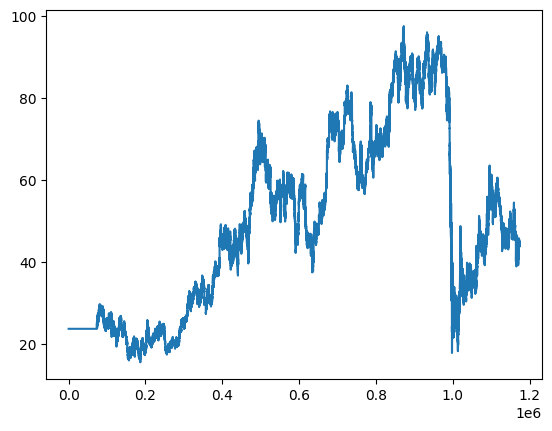

In [199]:
plt.plot(data)
plt.show()

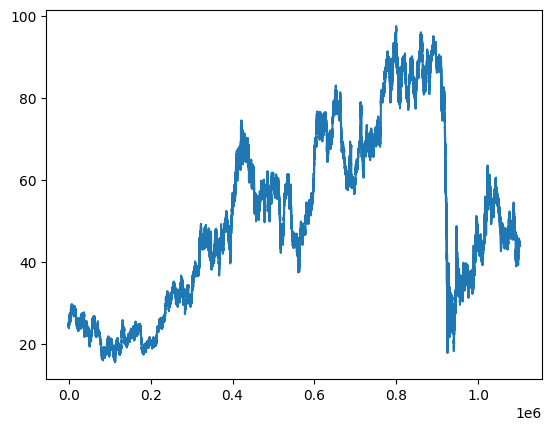

In [200]:
# Notice that the data is constant at the beginning
# We need to remove the constant part
for i in range(len(data)):
    if data[i] != data[0]:
        filtered_data = data[i:]
        break
data = filtered_data
plt.plot(data)
plt.show()

In [201]:
import pandas as pd

# We need to convert the data to 1 hour intervals with OHLC values
# We will use the first value of the hour as the open value, the last value of the hour as the close value
# The maximum value of the hour as the high value and the minimum value of the hour as the low value

num_hours = len(data) // 12
hourly_ohlc_df = pd.DataFrame(columns=['open', 'high', 'low', 'close'], index=range(num_hours))
for i in range(num_hours):
    hourly_ohlc_df.loc[i, 'open'] = data[i * 12]
    hourly_ohlc_df.loc[i, 'high'] = max(data[i * 12: (i + 1) * 12])
    hourly_ohlc_df.loc[i, 'low'] = min(data[i * 12 : (i + 1) * 12])
    hourly_ohlc_df.loc[i, 'close'] = data[(i + 1) * 12 - 1]

In [202]:
hourly_ohlc_df.head()

open       high        low      close
0       24.9       24.9  24.700001      24.77
1      24.75      24.82      24.75  24.799999
2  24.860001  24.860001     24.545     24.545
3     24.535     24.535  24.280001  24.469999
4      24.49      24.49       24.4  24.450001

In [203]:
import talib
from aroon_crossover._strategy import AroonCrossover as aroon
from bollinger_bands._strategy import BollingerBands as bollinger
from ema_regular_order._strategy import EMARegularOrder as ema
from inverse_ema_scalping_regular_order._strategy import InverseEMAScalpingRegularOrder as inverse_ema
from macd_crossover._strategy import MACDCrossover as macd
from mean_reversion_bollinger_bands._strategy import MeanReversionBollingerBands as mean_reversion
from reverse_rsi_crossover._strategy import ReverseRSICrossover as reverse_rsi
from rsi_macd_crossover._strategy import RSIMACDCrossover as rsi_macd
from stochastic_crossover._strategy import StochasticCrossover as stochastic
from volatility_trend_atr._strategy import VolatilityTrendATR as volatility_trend

parameters = {
    aroon: {
        'TIME_PERIOD': 12
    },
    bollinger: {
        'STANDARD_DEVIATIONS': 2.0, 
        'TIME_PERIOD': 7.0
    },
    ema: {
        'TIMEPERIOD1': 12, 
        'TIMEPERIOD2': 20
    },
    inverse_ema: {
        'LARGER_TIME_PERIOD': 7.0, 
        'SMALLER_TIME_PERIOD': 2.0
    },
    macd: {
        'TIMEPERIOD_FAST': 12.0, 
        'TIMEPERIOD_SIGNAL': 9.0,
        'TIMEPERIOD_SLOW': 26.0
    },
    mean_reversion: {
        'STD_DEVIATION': 20.0,
        'TIMEPERIOD': 2.0
    },
    reverse_rsi: {
        'OVERBOUGHT_VALUE': 70.0,
        'OVERSOLD_VALUE': 32.0,
        'TIME_PERIOD': 7.0
    },
    rsi_macd: {
        'OVERBOUGHT_VALUE': 85.0,
        'OVERSOLD_VALUE': 15.0,
        'TIMEPERIOD_FAST': 12.0,
        'TIMEPERIOD_RSI': 3.0,
        'TIMEPERIOD_SIGNAL': 9.0,
        'TIMEPERIOD_SLOW': 26.0
    },
    stochastic: {
        'FASTK_PERIOD': 7.0,
        'SLOWD_PERIOD': 2.0,
        'SLOWK_PERIOD': 2.0
    },
    volatility_trend: {
        'ATR_PREV_CANDLES_NUM': 70.0,
        'TIMEPERIOD_ATR': 20.0
    },
    vwap: {
        'TIMEPERIOD': 7.0
    }
}

def cross_over(list1_prev, list1_now, list2_prev, list2_now):
    if list1_prev <= list2_prev and list1_now > list2_now:
        return 1
    elif list1_prev >= list2_prev and list1_now < list2_now:
        return -1
    else:
        return 0

# Implement Wrappers for the strategies
class Aroon(aroon):
    def __init__(self, data):
        self.time_period = parameters[aroon]['TIME_PERIOD']
        self.aroon_up, self.aroon_down = talib.AROON(data['high'], data['low'], timeperiod=self.time_period)
    def signal(self, index):
        if index < 1 or self.aroon_up[index - 1] == np.nan or self.aroon_down[index - 1] == np.nan:
            return 0
        return cross_over(self.aroon_up[index - 1], self.aroon_up[index], self.aroon_down[index - 1], self.aroon_down[index])

class Bollinger(bollinger):
    def __init__(self, data):
        self.time_period = parameters[bollinger]['TIME_PERIOD']
        self.std_dev = parameters[bollinger]['STANDARD_DEVIATIONS']
        self.data = data
        self.upperband, self.middleband, self.lowerband = talib.BBANDS(data['close'], timeperiod=self.time_period, nbdevup=self.std_dev, nbdevdn=self.std_dev)
    def signal(self, index):
        if index < 1 or self.upperband[index - 1] == np.nan or self.middleband[index - 1] == np.nan or self.lowerband[index - 1] == np.nan:
            return 0
        upper_band_value = self.upperband.iloc[index]
        lower_band_value = self.lowerband.iloc[index]
        latest_candle = self.data.iloc[index]
        previous_candle = self.data.iloc[index - 1]
        if (previous_candle['open'] <= lower_band_value or previous_candle['high'] <= lower_band_value or previous_candle['low'] <= lower_band_value or previous_candle['close'] <= lower_band_value) and \
                (latest_candle['close'] > previous_candle['close']):
            return 1
        elif (previous_candle['open'] >= upper_band_value or previous_candle['high'] >= upper_band_value or previous_candle['low'] >= upper_band_value or previous_candle['close'] >= upper_band_value) and \
                (latest_candle['close'] < previous_candle['close']):
            return -1
        else:
            return 0

class EMA(ema):
    def __init__(self, data):
        self.time_period1 = parameters[ema]['TIMEPERIOD1']
        self.time_period2 = parameters[ema]['TIMEPERIOD2']
        self.ema1 = talib.EMA(data['close'], timeperiod=self.time_period1)
        self.ema2 = talib.EMA(data['close'], timeperiod=self.time_period2)
    def signal(self, index):
        if index < 1 or self.ema1[index - 1] == np.nan or self.ema2[index - 1] == np.nan:
            return 0
        return cross_over(self.ema1[index - 1], self.ema1[index], self.ema2[index - 1], self.ema2[index])

class InverseEMA(inverse_ema):
    def __init__(self, data):
        self.larger_time_period = parameters[inverse_ema]['LARGER_TIME_PERIOD']
        self.smaller_time_period = parameters[inverse_ema]['SMALLER_TIME_PERIOD']
        self.ema_larger = talib.EMA(data['close'], timeperiod=self.larger_time_period)
        self.ema_smaller = talib.EMA(data['close'], timeperiod=self.smaller_time_period)
    def signal(self, index):
        if index < 1 or self.ema_larger[index - 1] == np.nan or self.ema_smaller[index - 1] == np.nan:
            return 0
        return cross_over(self.ema_smaller[index - 1], self.ema_smaller[index], self.ema_larger[index - 1], self.ema_larger[index])

class MACD(macd):
    def __init__(self, data):
        self.fast_period = parameters[macd]['TIMEPERIOD_FAST']
        self.slow_period = parameters[macd]['TIMEPERIOD_SLOW']
        self.signal_period = parameters[macd]['TIMEPERIOD_SIGNAL']
        self.macdline, self.macdsignal, self.hist = talib.MACD(data['close'], fastperiod=self.fast_period, slowperiod=self.slow_period, signalperiod=self.signal_period)
    def signal(self, index):
        if index < 1 or self.macdline[index - 1] == np.nan or self.macdsignal[index - 1] == np.nan:
            return 0
        return cross_over(self.macdline[index - 1], self.macdline[index], self.macdsignal[index - 1], self.macdsignal[index])

class MeanReversion(mean_reversion):
    def __init__(self, data):
        self.std_dev = parameters[mean_reversion]['STD_DEVIATION']
        self.time_period = parameters[mean_reversion]['TIMEPERIOD']
        self.data = data
        self.upperband, self.middleband, self.lowerband = talib.BBANDS(data['close'], timeperiod=self.time_period, nbdevup=self.std_dev, nbdevdn=self.std_dev, matype=0)
    def signal(self, index):
        if index < 1 or self.upperband[index - 1] == np.nan or self.middleband[index - 1] == np.nan or self.lowerband[index - 1] == np.nan:
            return 0
        upper_band_value = self.upperband.iloc[index]
        lower_band_value = self.lowerband.iloc[index]
        latest_candle = self.data.iloc[index]
        previous_candle = self.data.iloc[index - 1]
        if (previous_candle['open'] <= lower_band_value or previous_candle['low'] <= lower_band_value) and (latest_candle['close'] > previous_candle['close']):
            return 1
        elif (previous_candle['open'] >= upper_band_value or previous_candle['close'] >= upper_band_value) and (latest_candle['close'] < previous_candle['close']):
            return -1
        else:
            return 0

class ReverseRSI(reverse_rsi):
    def __init__(self, data):
        self.overbought_value = parameters[reverse_rsi]['OVERBOUGHT_VALUE']
        self.oversold_value = parameters[reverse_rsi]['OVERSOLD_VALUE']
        self.time_period = parameters[reverse_rsi]['TIME_PERIOD']
        self.rsi = talib.RSI(data['close'], timeperiod=self.time_period)
    def signal(self, index):
        if index < 1 or self.rsi[index - 1] == np.nan:
            return 0
        if self.rsi[index - 1] < self.oversold_value and self.rsi[index] > self.oversold_value:
            return 1
        elif self.rsi[index - 1] > self.overbought_value and self.rsi[index] < self.overbought_value:
            return -1
        else:
            return 0

class RSIMACD(rsi_macd):
    def __init__(self, data):
        self.overbought_value = parameters[rsi_macd]['OVERBOUGHT_VALUE']
        self.oversold_value = parameters[rsi_macd]['OVERSOLD_VALUE']
        self.time_period_fast = parameters[rsi_macd]['TIMEPERIOD_FAST']
        self.time_period_rsi = parameters[rsi_macd]['TIMEPERIOD_RSI']
        self.time_period_signal = parameters[rsi_macd]['TIMEPERIOD_SIGNAL']
        self.time_period_slow = parameters[rsi_macd]['TIMEPERIOD_SLOW']
        self.macdline, self.macdsignal, self.hist = talib.MACD(data['close'], fastperiod=self.time_period_fast, slowperiod=self.time_period_slow, signalperiod=self.time_period_signal)
        self.rsi = talib.RSI(self.macdsignal, timeperiod=self.time_period_rsi)
    def signal(self, index):
        if index < 1 or self.rsi[index - 1] == np.nan or self.macdline[index - 1] == np.nan or self.macdsignal[index - 1] == np.nan:
            return 0
        if self.rsi[index - 1] < self.oversold_value and self.rsi[index] > self.oversold_value and self.macdline[index] > self.macdsignal[index]:
            return 1
        elif self.rsi[index - 1] > self.overbought_value and self.rsi[index] < self.overbought_value and self.macdline[index] < self.macdsignal[index]:
            return -1
        else:
            return 0
    
class Stochastic(stochastic):
    def __init__(self, data):
        self.fastk_period = parameters[stochastic]['FASTK_PERIOD']
        self.slowd_period = parameters[stochastic]['SLOWD_PERIOD']
        self.slowk_period = parameters[stochastic]['SLOWK_PERIOD']
        self.slowk, self.slowd = talib.STOCH(data['high'], data['low'], data['close'], fastk_period=self.fastk_period, slowk_period=self.slowk_period, slowd_period=self.slowd_period, slowk_matype=0, slowd_matype=0)
    def signal(self, index):    
        if index < 1 or self.slowk[index - 1] == np.nan or self.slowd[index - 1] == np.nan:
            return 0
        return cross_over(self.slowk[index - 1], self.slowk[index], self.slowd[index - 1], self.slowd[index])

class VolatilityTrend(volatility_trend):
    def __init__(self, data):
        self.atr_prev_candles_num = parameters[volatility_trend]['ATR_PREV_CANDLES_NUM']
        self.time_period_atr = parameters[volatility_trend]['TIMEPERIOD_ATR']
        self.atr = talib.ATR(data['high'], data['low'], data['close'], timeperiod=self.time_period_atr)
    def signal(self, index):
        if index < self.atr_prev_candles_num or self.atr[index - self.atr_prev_candles_num] == np.nan:
            return 0
        current_atr = self.atr[index]
        atr_prev_candles_num  = self.atr[index - self.atr_prev_candles_num]
        return 1 if current_atr > atr_prev_candles_num else -1 if current_atr < atr_prev_candles_num else 0

# VWAP is not possible to implement as it requires the volume data    

strategies = [Aroon, Bollinger, EMA, InverseEMA, MACD, MeanReversion, ReverseRSI, RSIMACD, Stochastic, VolatilityTrend]
strategy_to_name = {
    Aroon: 'Aroon',
    Bollinger: 'Bollinger',
    EMA: 'EMA',
    InverseEMA: 'InverseEMA',
    MACD: 'MACD',
    MeanReversion: 'MeanReversion',
    ReverseRSI: 'ReverseRSI',
    RSIMACD: 'RSIMACD',
    Stochastic: 'Stochastic',
    VolatilityTrend: 'VolatilityTrend'
}

class Backtester:
    def __init__(self, data, strategies):
        self.data = data
        self.strategies = strategies
        self.position = 0
        self.equity = 10000
        self.equity_curve = [self.equity]
        self.trade_log = []
        self.equity_curve_list = {}
        self.trade_log_list = {}
        self.instances = {}

    def backtest_all_strategies(self):
        for strategy in self.strategies:
            strategy_instance = strategy(self.data)
            self.instances[strategy] = strategy_instance
            self.backtest(strategy_instance, strategy_to_name[strategy])
            
            self.equity = 10000
            self.equity_curve_list[strategy] = self.equity_curve
            self.trade_log_list[strategy] = self.trade_log
            self.equity_curve = [self.equity]
            self.trade_log = []
            self.position = 0
    
    def backtest(self, strategy, name):
        entryPrice = None
        for i in range(1, len(self.data)):
            signal = strategy.signal(i)
            if signal == 1:                    
                if self.position != 1:
                    self.trade_log.append((i, 'buy', self.data.loc[i, 'close']))
                if self.position == 0:
                    self.position = 1
                    entryPrice = self.data.loc[i, 'close']
                elif self.position == -1:
                    self.position = 0
                    self.equity = (1 + (entryPrice - self.data.loc[i, 'close']) / entryPrice) * self.equity
                    entryPrice = None
            elif signal == -1:
                if self.position != -1:
                    self.trade_log.append((i, 'sell', self.data.loc[i, 'close']))
                if self.position == 0:
                    self.position = -1
                    entryPrice = self.data.loc[i, 'close']
                if self.position == 1:
                    self.position = 0
                    self.equity = (1 + (self.data.loc[i, 'close'] - entryPrice) / entryPrice) * self.equity
                    entryPrice = None
            self.equity_curve.append(self.equity)
        self.equity_curve = np.array(self.equity_curve)
        ending_equity = self.equity_curve[-1]
        print(f"The return of {name} Strategy on UAL is ", (ending_equity - 10000) / 10000 * 100, "%")

    def plot_equity_curves(self, index=len(data)-1):
        for strategy in self.strategies:
            plt.plot(self.equity_curve_list[strategy][:index])
            title = "Equity Curve for " + strategy_to_name[strategy] + " Strategy"
            plt.title(title)
            plt.show()
    

In [204]:
backtester = Backtester(hourly_ohlc_df, strategies)

In [205]:
backtester.backtest_all_strategies()

The return of Aroon Strategy on UAL is  -50.66658232135756 %
The return of Bollinger Strategy on UAL is  551.9009081709671 %
The return of EMA Strategy on UAL is  -55.199875126607346 %
The return of InverseEMA Strategy on UAL is  2.5541359331648894 %
The return of MACD Strategy on UAL is  -87.89858000945554 %
The return of MeanReversion Strategy on UAL is  136.12588875412303 %
The return of ReverseRSI Strategy on UAL is  -84.98165492450192 %
The return of RSIMACD Strategy on UAL is  -7.660182050186813 %
The return of Stochastic Strategy on UAL is  83.9364161086869 %
The return of VolatilityTrend Strategy on UAL is  -98.10904362032495 %


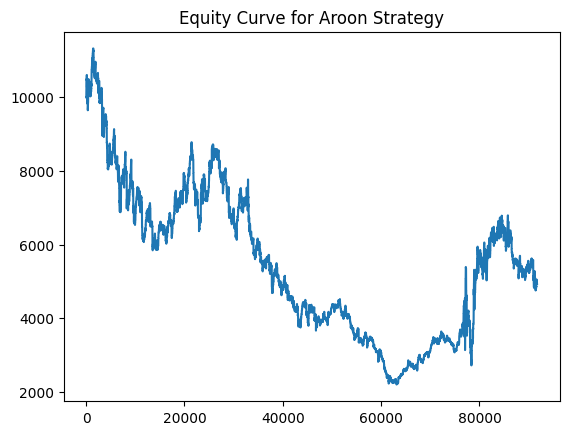

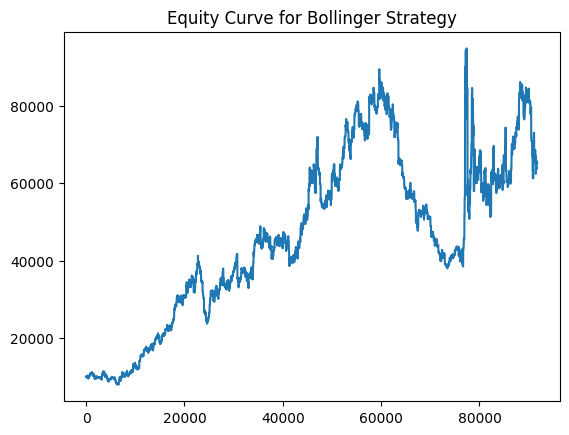

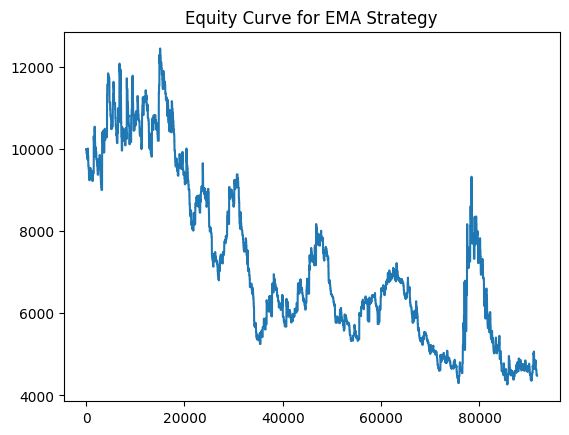

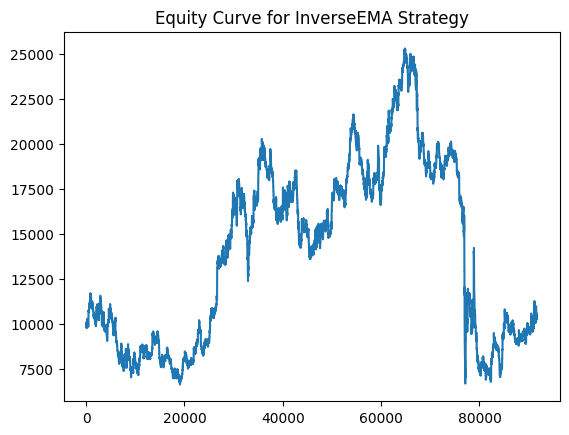

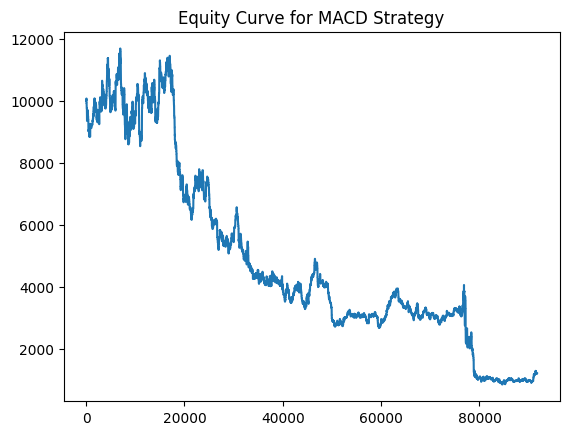

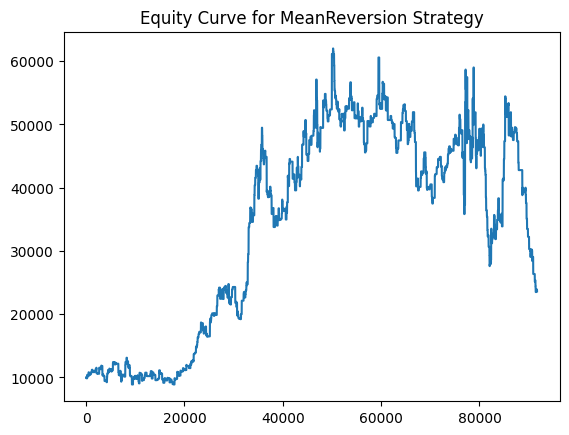

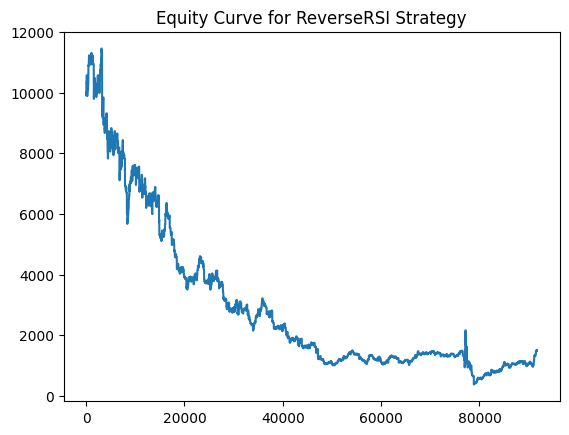

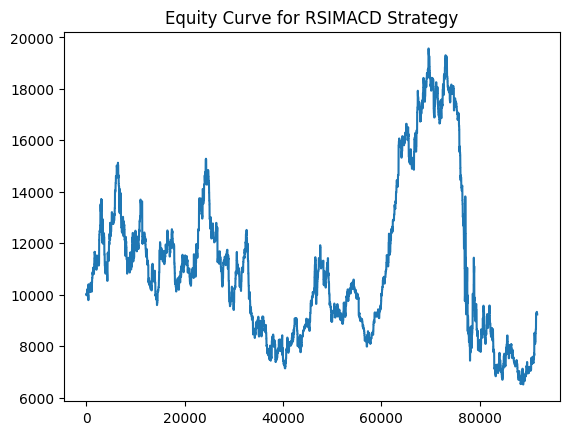

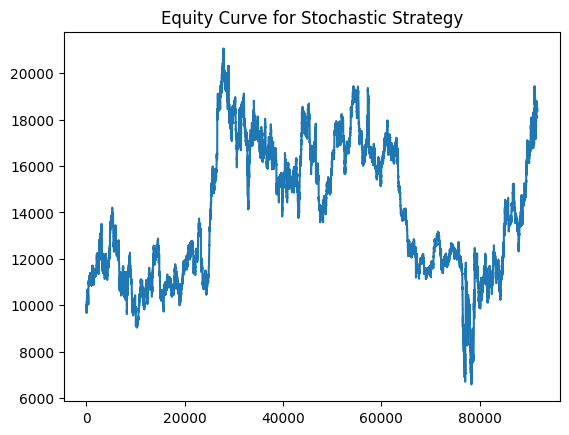

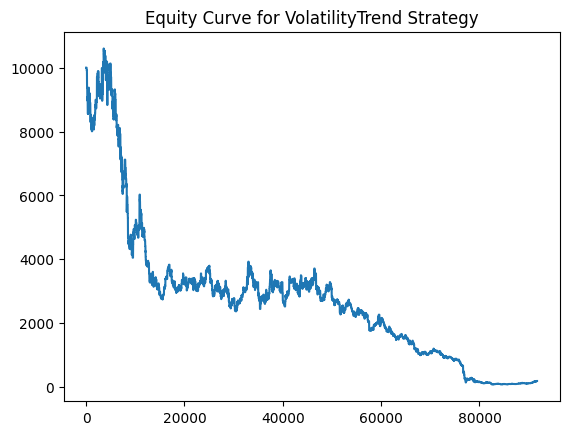

In [206]:
backtester.plot_equity_curves()

In [207]:
import plotly.graph_objects as go

def plot_candlestick(data, trades):
    fig = go.Figure(data=[go.Candlestick(x=data.index,
                open=data['open'],
                high=data['high'],
                low=data['low'],
                close=data['close'])])
    # Add buy and sell signals
    trades = list(filter(lambda x: x[0] <= len(data), trades))
    print(trades)
    longs = list(filter(lambda x: x[1] == 'buy', trades))
    long_indexs = [(lambda x: x[0])(x) for x in longs]
    long_prices = [(lambda x: x[2])(x) * 0.99 for x in longs]
    shorts = list(filter(lambda x: x[1] == 'sell', trades))
    short_indexs = [(lambda x: x[0])(x) for x in shorts]
    short_prices = [(lambda x: x[2])(x) * 1.01 for x in shorts]
    fig.add_trace(go.Scatter(x=long_indexs, y=long_prices, mode='markers', name='Buy', marker_color='green', marker_symbol='triangle-up', marker_size=10))
    fig.add_trace(go.Scatter(x=short_indexs, y=short_prices, mode='markers', name='Sell', marker_color='red', marker_symbol='triangle-down', marker_size=10))
    fig.show()

def plot_aroon_chart(data, aroon):
    # Plot the Aroon Up and Aroon Down
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data.index, y=aroon.aroon_up, mode='lines', name='Aroon Up', line=dict(color='blue')))
    fig.add_trace(go.Scatter(x=data.index, y=aroon.aroon_down, mode='lines', name='Aroon Down', line=dict(color='red')))
    fig.show()

index = 200
plot_candlestick(hourly_ohlc_df[:index], backtester.trade_log_list[Aroon][:index])
plot_aroon_chart(hourly_ohlc_df[:index], backtester.instances[Aroon])

[(15, 'sell', 24.69), (31, 'buy', 24.655), (33, 'sell', 25.35), (36, 'buy', 24.6501), (50, 'sell', 24.48), (59, 'buy', 24.0), (65, 'sell', 24.47), (80, 'buy', 24.52), (90, 'sell', 24.58), (96, 'buy', 24.52), (109, 'sell', 25.01), (118, 'buy', 24.75), (124, 'sell', 24.89), (153, 'buy', 25.67), (154, 'sell', 25.58), (165, 'buy', 25.57), (169, 'sell', 25.97), (190, 'buy', 26.73), (197, 'buy', 26.44)]
